# Data analysis

The goal of this notebook is to analyze the timeseries and build a proof of concept for the forecast algorithm. We are interested in predicting one day at a time! We will start by importing and analyzing the data.

## Preliminaries

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import sys

sys.path.insert(0, "..")
from src import data, config, visualization, preprocessing, utils, features, models

/home/nchagnet/pyenvs/energy_demand_py/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
energy_df = data.load_energy()

Most of the energy data is clean, though with some null values.

In [5]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48192 entries, 2019-01-01 00:00:00+00:00 to 2024-06-30 23:00:00+00:00
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   load_forecast_day_ahead  48192 non-null  int64  
 1   load_actual              48141 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.1 MB


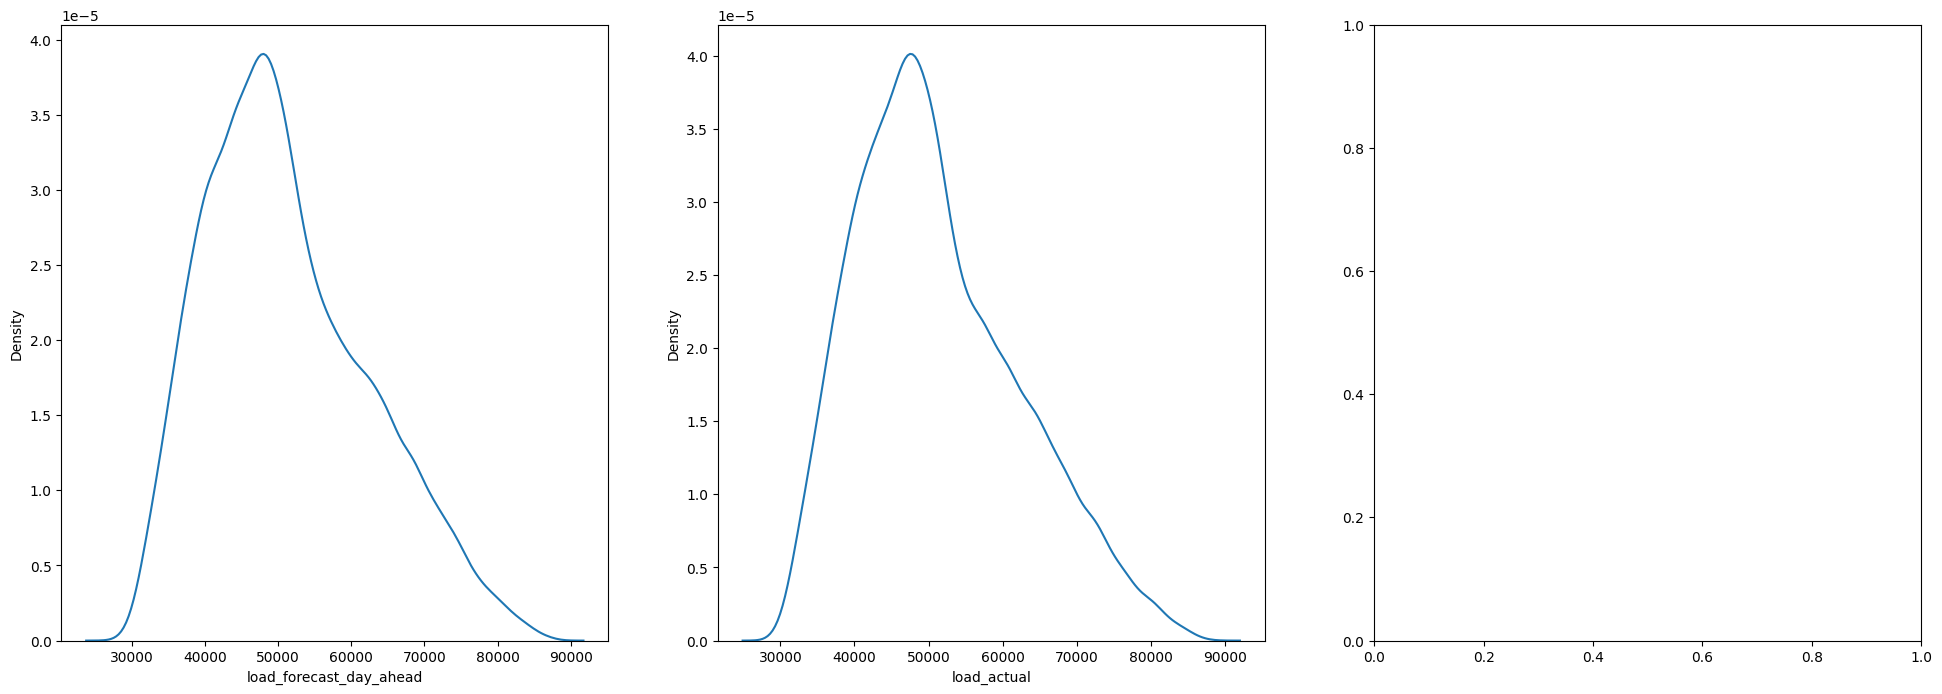

In [6]:
visualization.plot_distributions(energy_df.dropna())

In [7]:
# Useful index values
last_week = energy_df.index >= (energy_df.index[-1] - pd.Timedelta(weeks=1))
last_month = energy_df.index >= (energy_df.index[-1] - pd.Timedelta(weeks=4))
last_year = energy_df.index >= (energy_df.index[-1] - pd.Timedelta(days=365))

### Basic analysis and missing values

<Axes: xlabel='Time', ylabel='load_actual'>

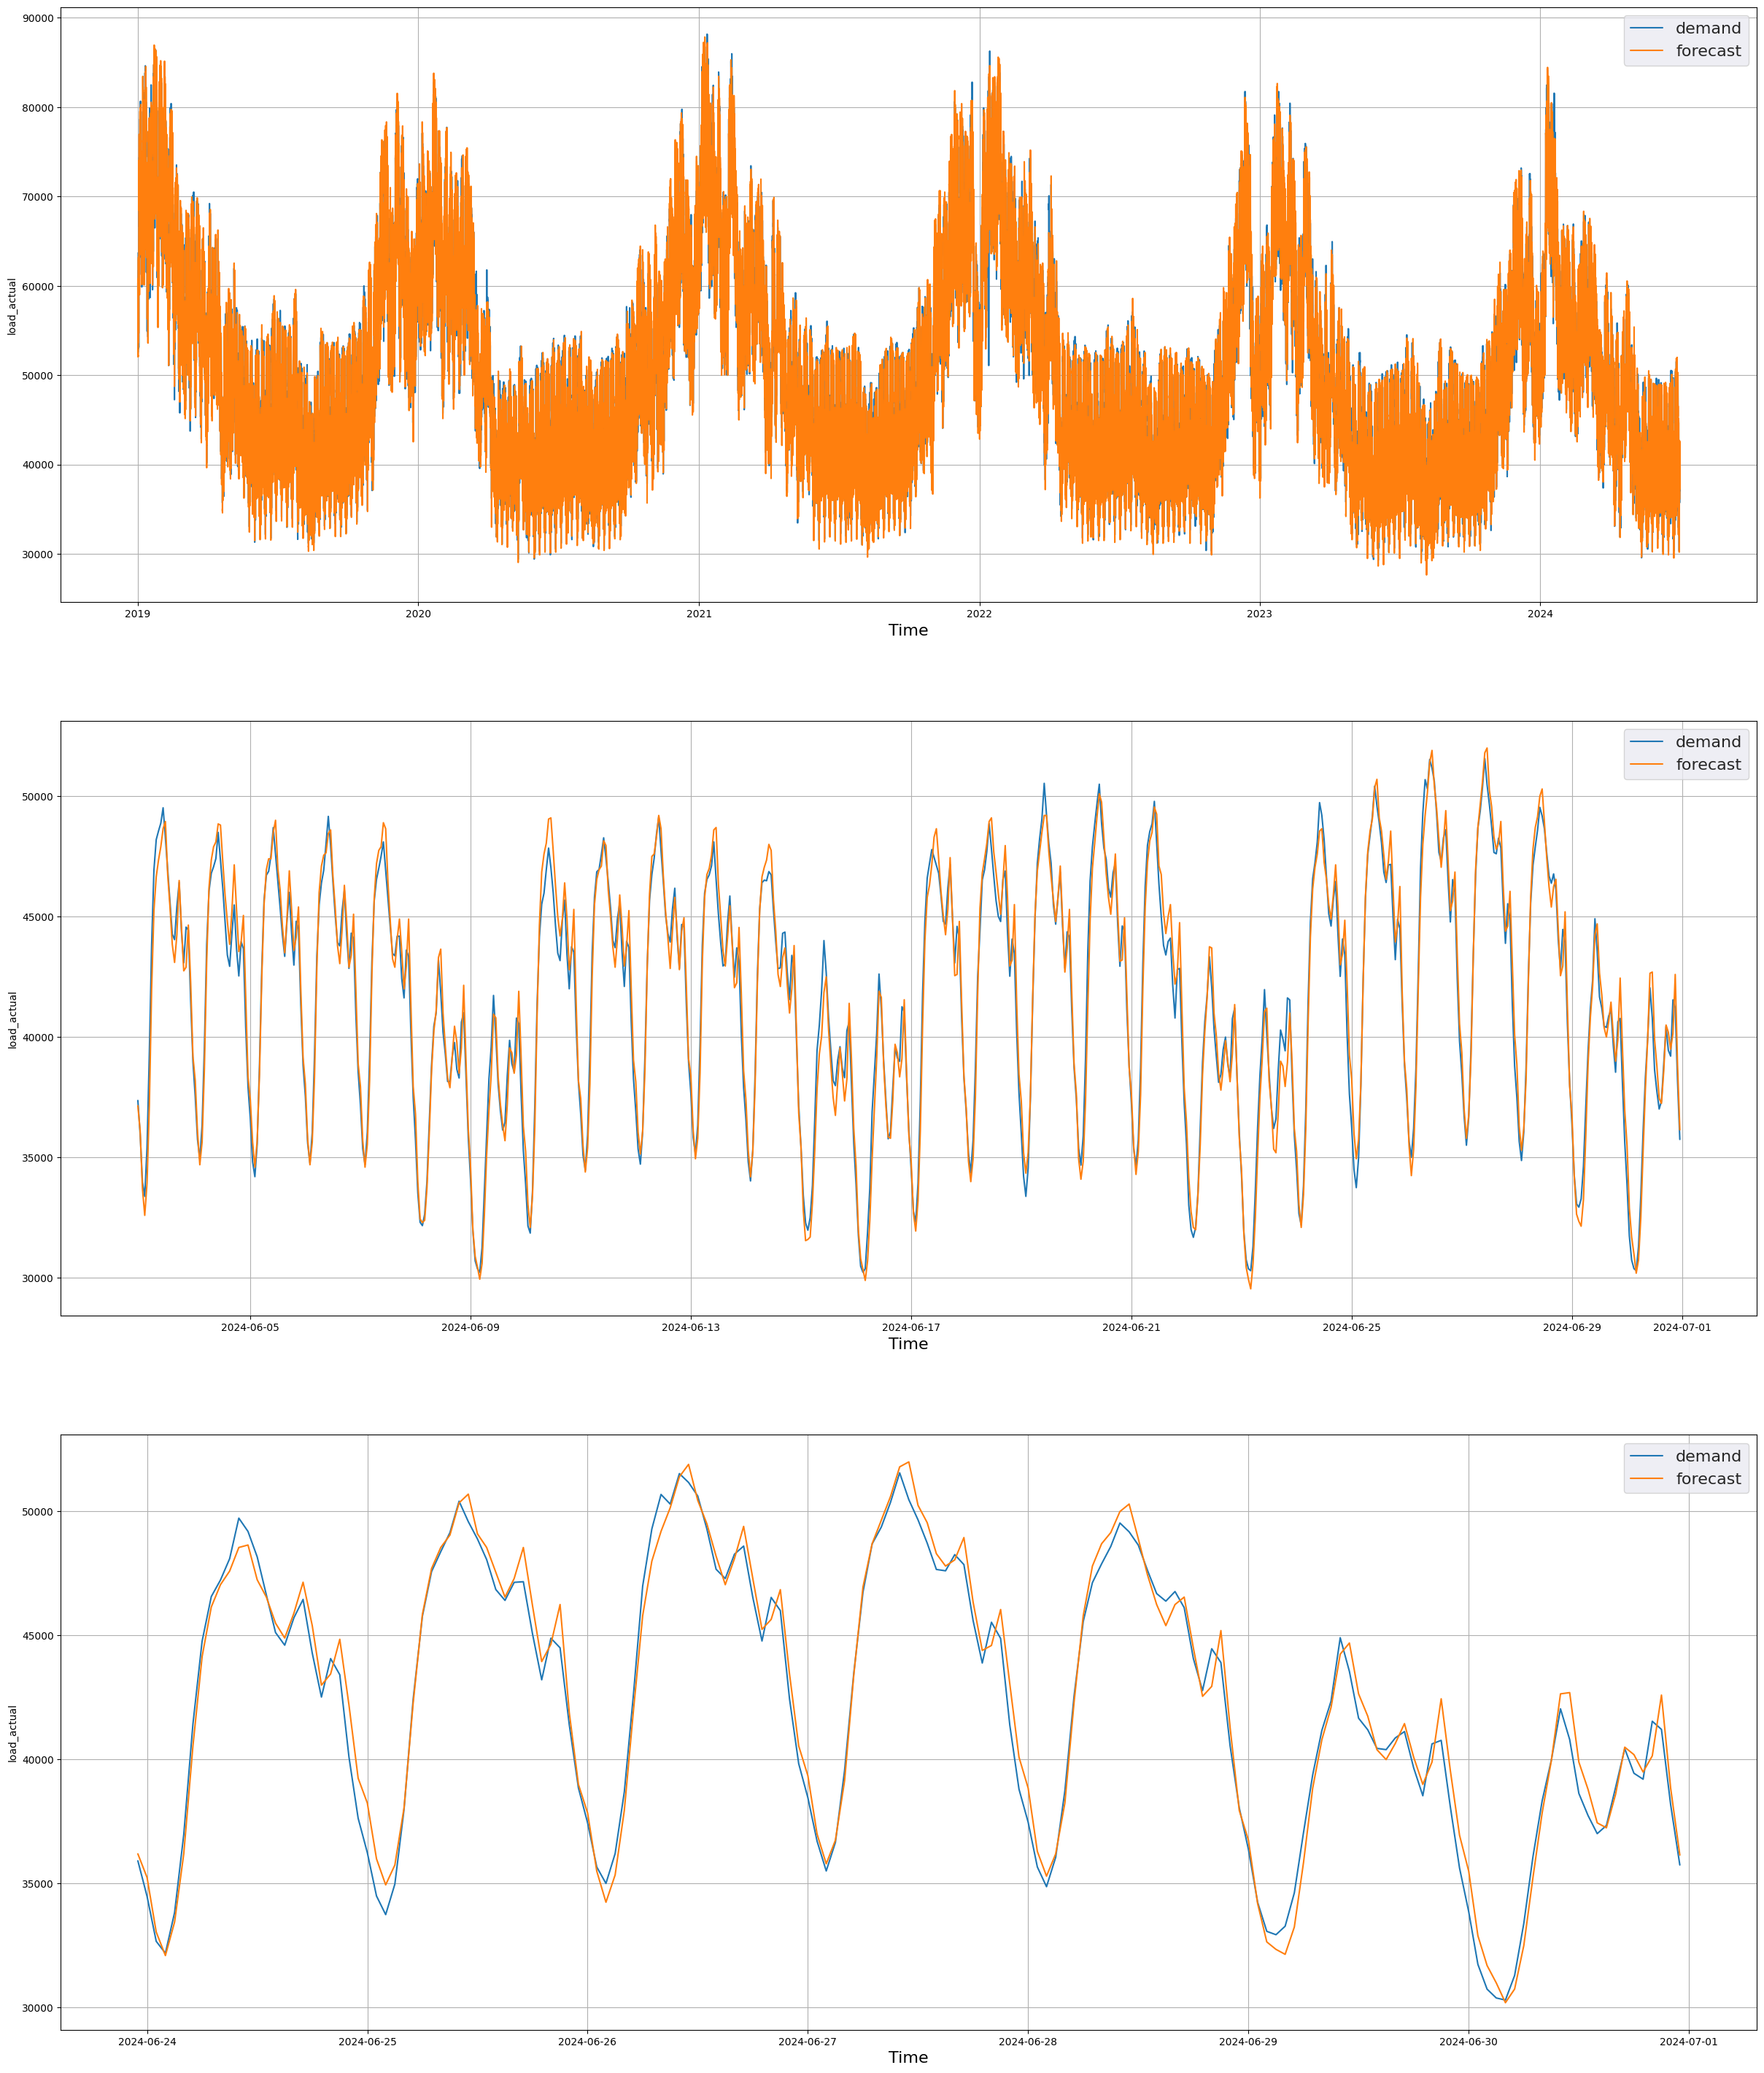

In [8]:
fig, axs = plt.subplots(nrows=3, figsize=(30, 12 * 3))
visualization.plot_series(energy_df["load_actual"], ax=axs[0], label="demand")
visualization.plot_series(energy_df["load_forecast_day_ahead"], ax=axs[0], label="forecast")

visualization.plot_series(energy_df.loc[last_month, "load_actual"], ax=axs[1], label="demand")
visualization.plot_series(energy_df.loc[last_month, "load_forecast_day_ahead"], ax=axs[1], label="forecast")

visualization.plot_series(energy_df.loc[last_week, "load_actual"], ax=axs[2], label="demand")
visualization.plot_series(energy_df.loc[last_week, "load_forecast_day_ahead"], ax=axs[2], label="forecast")

We fill null values using linear interpolation since the null values never account for more than a few hours in a row.

In [9]:
load_actual_nans = energy_df.loc[energy_df["load_actual"].isna(), "load_actual"]
display(load_actual_nans)
energy_df = preprocessing.LinearlyInterpolateTS(
    cols=["load_actual", "load_forecast_day_ahead"], method="linear", limit_direction="forward"
).fit_transform(energy_df)

time
2019-04-15 09:00:00+00:00   NaN
2019-04-15 10:00:00+00:00   NaN
2019-07-25 00:00:00+00:00   NaN
2019-07-25 01:00:00+00:00   NaN
2019-07-25 02:00:00+00:00   NaN
2019-07-25 03:00:00+00:00   NaN
2019-07-25 04:00:00+00:00   NaN
2019-10-27 00:00:00+00:00   NaN
2020-10-25 00:00:00+00:00   NaN
2020-12-07 11:00:00+00:00   NaN
2021-01-03 22:00:00+00:00   NaN
2021-02-24 08:00:00+00:00   NaN
2021-05-12 08:00:00+00:00   NaN
2021-05-19 04:00:00+00:00   NaN
2021-06-03 16:00:00+00:00   NaN
2021-10-31 00:00:00+00:00   NaN
2021-10-31 01:00:00+00:00   NaN
2021-11-17 10:00:00+00:00   NaN
2021-11-18 10:00:00+00:00   NaN
2022-01-10 10:00:00+00:00   NaN
2022-01-10 11:00:00+00:00   NaN
2022-01-10 12:00:00+00:00   NaN
2022-01-10 13:00:00+00:00   NaN
2022-01-10 14:00:00+00:00   NaN
2022-01-10 15:00:00+00:00   NaN
2022-01-12 08:00:00+00:00   NaN
2022-01-17 12:00:00+00:00   NaN
2022-01-19 07:00:00+00:00   NaN
2022-01-19 08:00:00+00:00   NaN
2022-01-27 20:00:00+00:00   NaN
2022-01-28 00:00:00+00:00   NaN
202

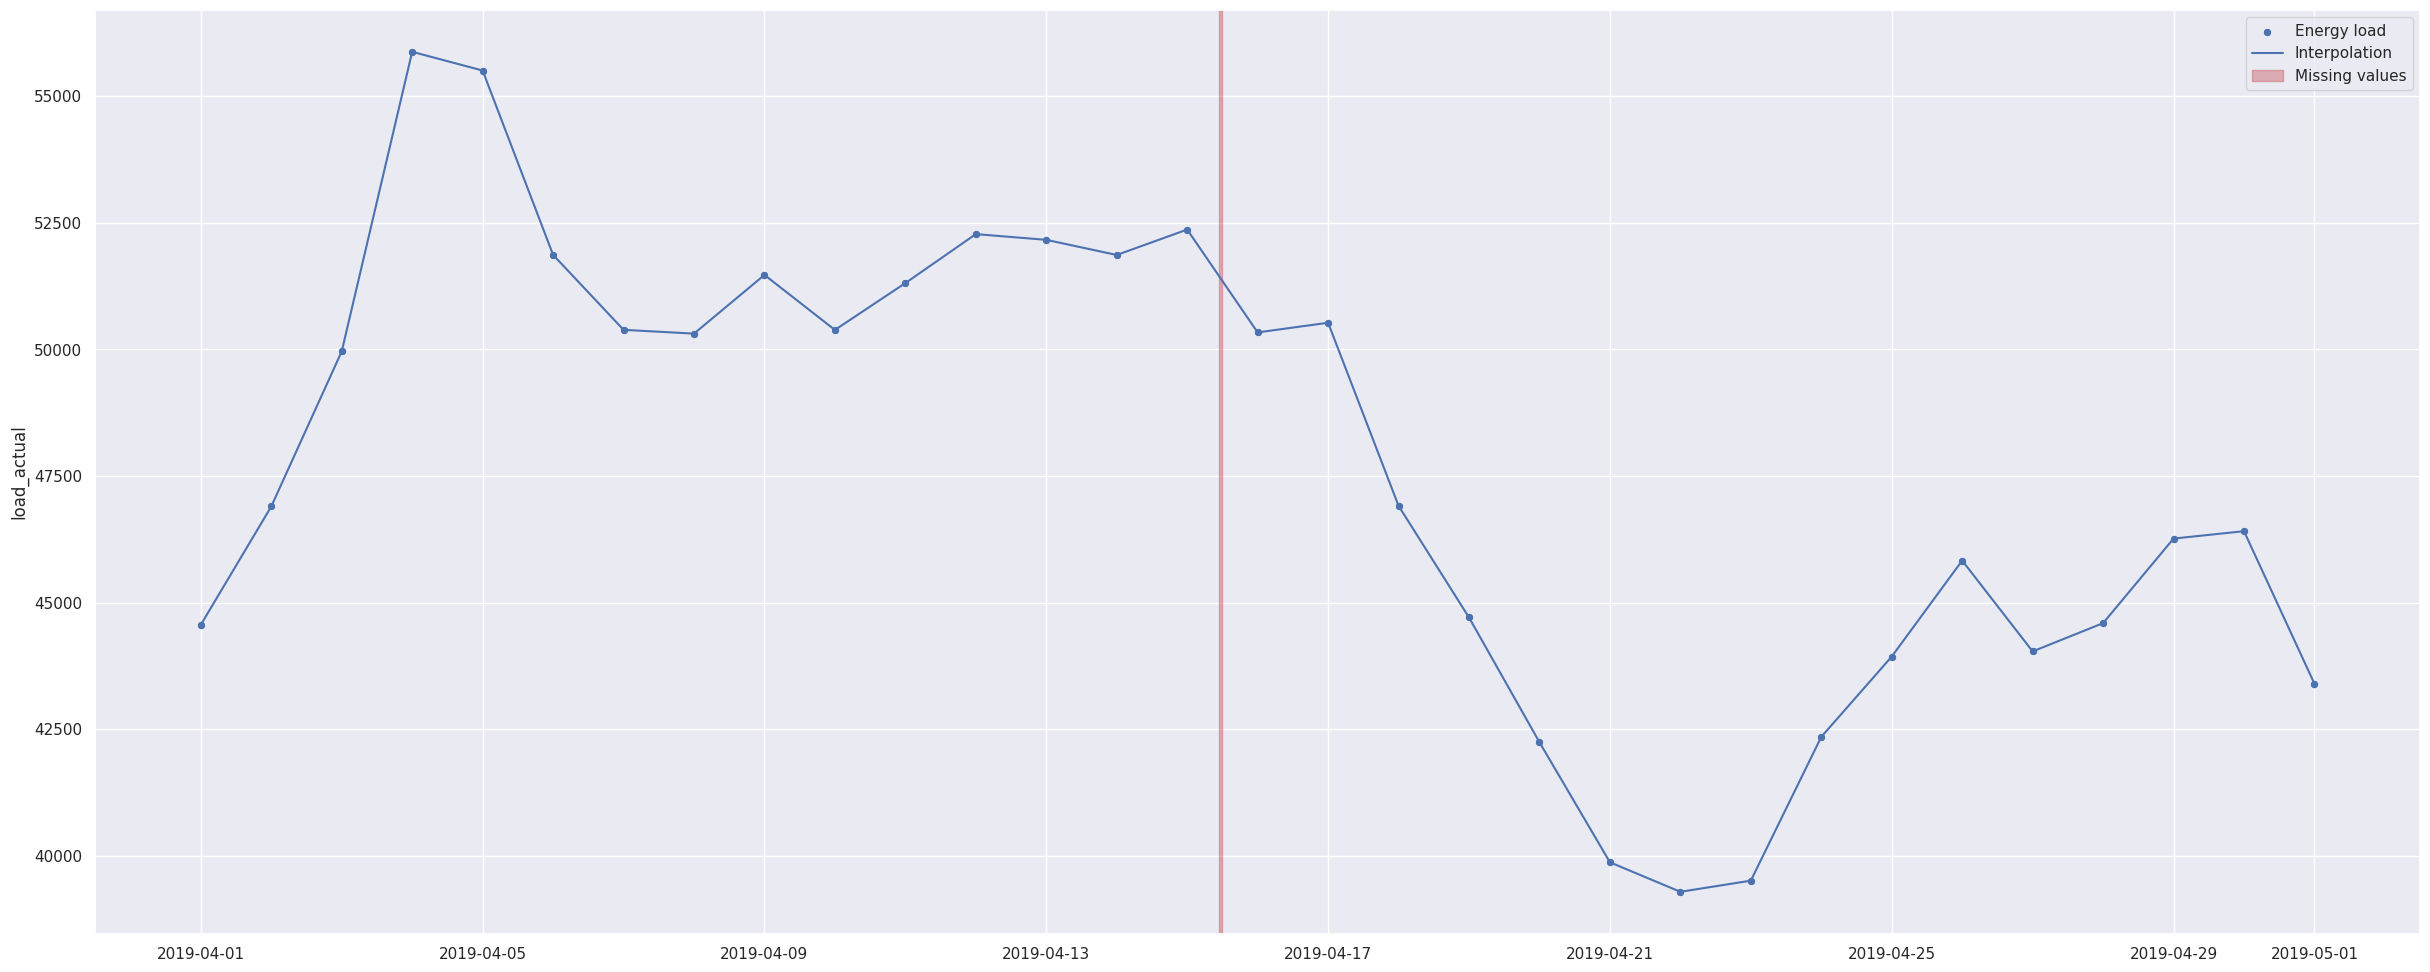

In [10]:
fig, ax = plt.subplots(figsize=(30, 12))
zoomed = pd.date_range(start="2019-04-01 00:00:00+00:00", end="2019-05-01 00:00:00+00:00")
sns.scatterplot(energy_df.loc[zoomed, "load_actual"], ax=ax, label="Energy load")
sns.lineplot(energy_df.loc[zoomed, "load_actual_interpolated"], ax=ax, label="Interpolation")
ax.axvspan("2019-04-15 11:00:00+00:00", "2019-04-15 12:00:00+00:00", alpha=0.4, color="r", label="Missing values")
ax.legend()

In [11]:
from sklearn.metrics import mean_absolute_percentage_error

print(
    f'Forecast MAPE: {mean_absolute_percentage_error(energy_df["load_actual_interpolated"], energy_df["load_forecast_day_ahead_interpolated"])}'
)
print(
    f'Forecast MAPE (last year): {mean_absolute_percentage_error(energy_df.loc[last_year, "load_actual_interpolated"], energy_df.loc[last_year, "load_forecast_day_ahead_interpolated"])}'
)

Forecast MAPE: 0.01984310553909185
Forecast MAPE (last year): 0.02703697763717789


In [12]:
y = energy_df["load_actual_interpolated"]
y = y.asfreq("h")
display(y.isna().sum() == 0)

y_day_ahead = energy_df["load_forecast_day_ahead"]
y_day_ahead = y_day_ahead.asfreq("h")

True

In [13]:
# We define a one day forecast horizon in our training
predict_size = 24
refit_size = 7
delta_forecast = pd.Timedelta(hours=predict_size)
delta_val = pd.Timedelta(hours=predict_size * refit_size * 2)
start_train = "2019-01-01"

idx_forecast = y.index > (y.index[-1] - delta_forecast)
idx_train = (y.index >= start_train) & (~idx_forecast)
idx_val = (~idx_forecast) & (y.index > y.index[-1] - delta_forecast - delta_val)
idx_train_noval = (idx_train) & (~idx_val)
print(f"Number of backtesting steps: {(idx_train.sum() - idx_train_noval.sum())/24}")

Number of backtesting steps: 14.0


### Seasonality

We can find the seasonality of the timeseries by looking at its Fourier transform and the power density for each Fourier components (a *periodogram*). From this plot, we see a twice-daily seasonality (indicator of night and day patterns), a daily seasonality (daily pattern of energy demand), a weekly seasonality, and finally yearly and biannual period.

Periods in hours: [8.0280e+03 9.6340e+03 2.4000e+01 4.3790e+03 1.2000e+01 1.6800e+02
 6.8810e+03 6.0210e+03 2.4084e+04 1.0950e+03 4.8168e+04 1.7840e+03
 1.4600e+03 8.4000e+01 2.4080e+03]
Periods in days: [3.340e+02 4.010e+02 1.000e+00 1.820e+02 0.000e+00 7.000e+00 2.870e+02
 2.510e+02 1.004e+03 4.600e+01 2.007e+03 7.400e+01 6.100e+01 4.000e+00
 1.000e+02]


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

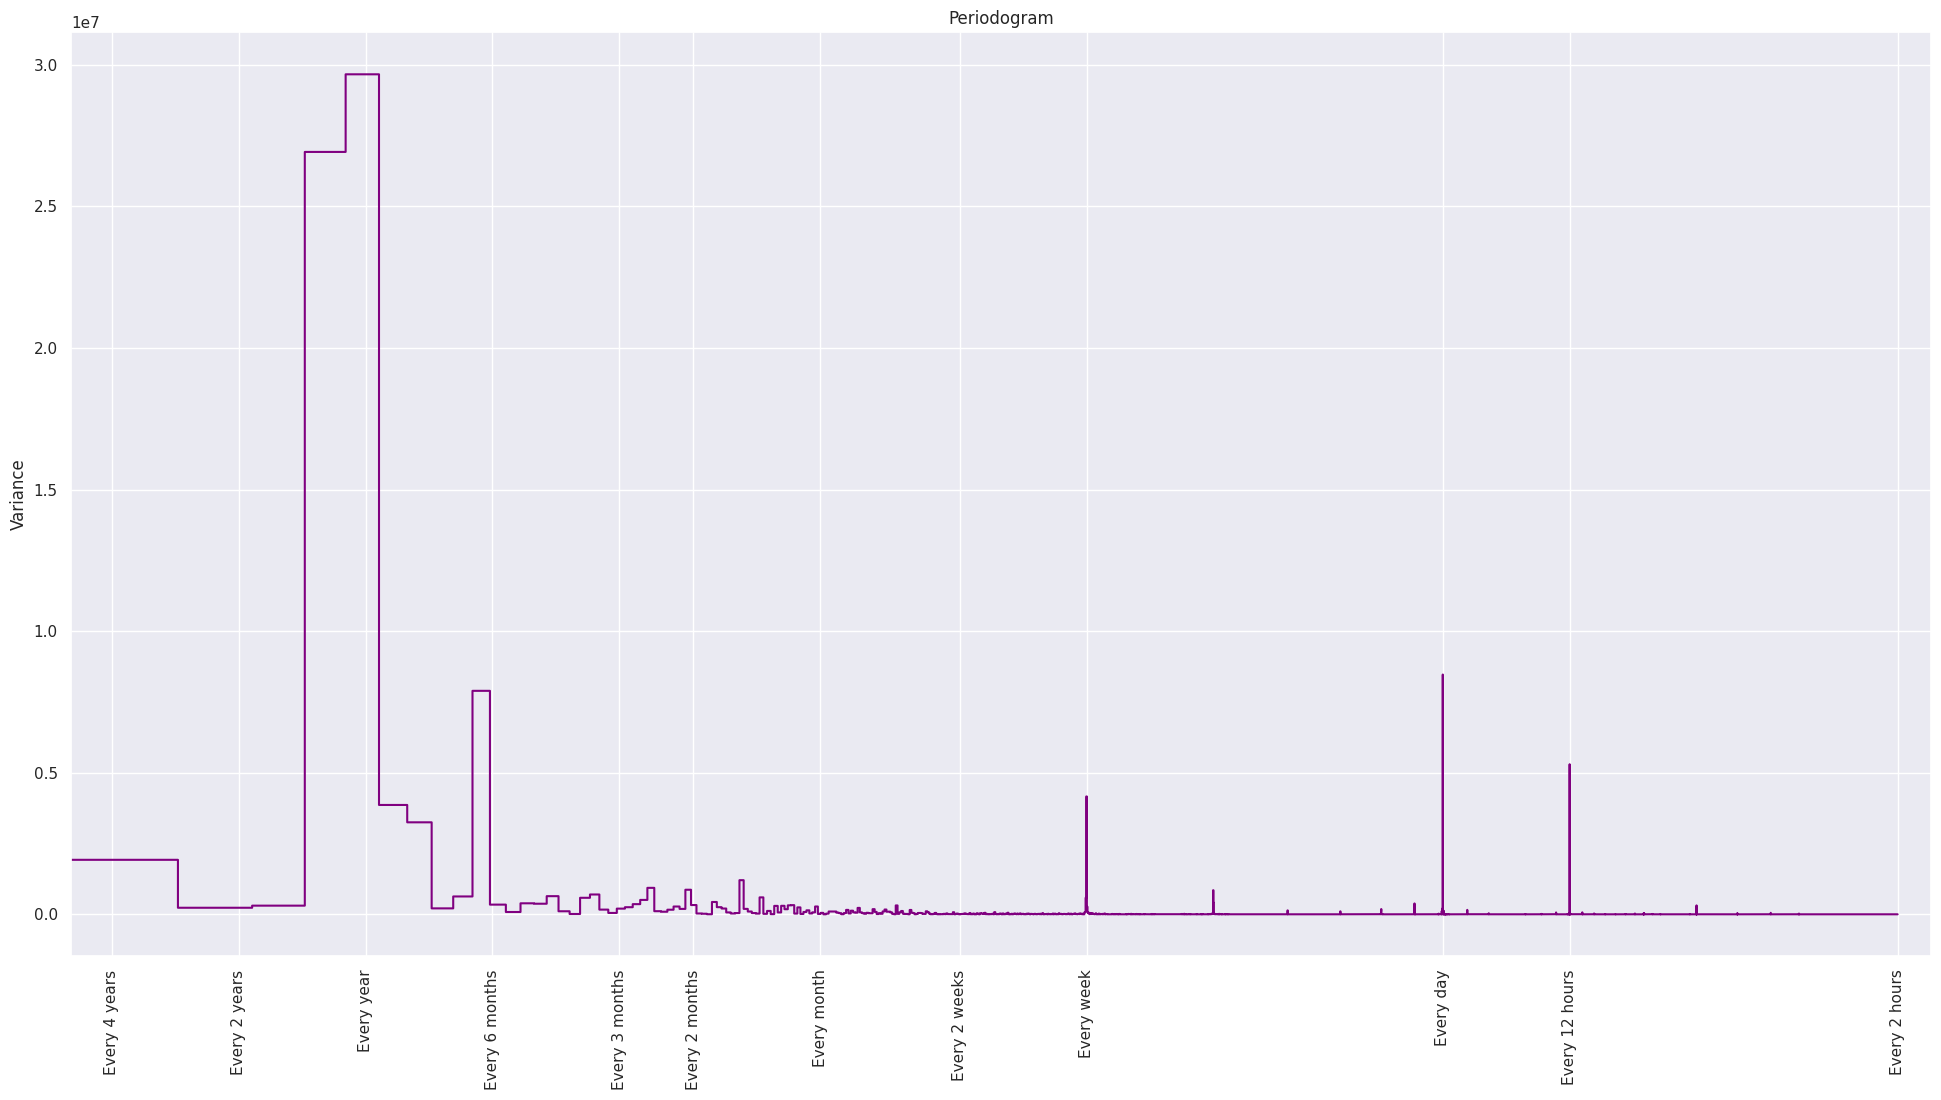

In [14]:
frequencies, spectrum, max_periods, max_spectrum = utils.compute_periodogram(y.loc[idx_train], 15)
print(f"Periods in hours: {max_periods.round()}")
print(f"Periods in days: {(max_periods/24).round()}")
visualization.plot_periodogram(frequencies, spectrum)

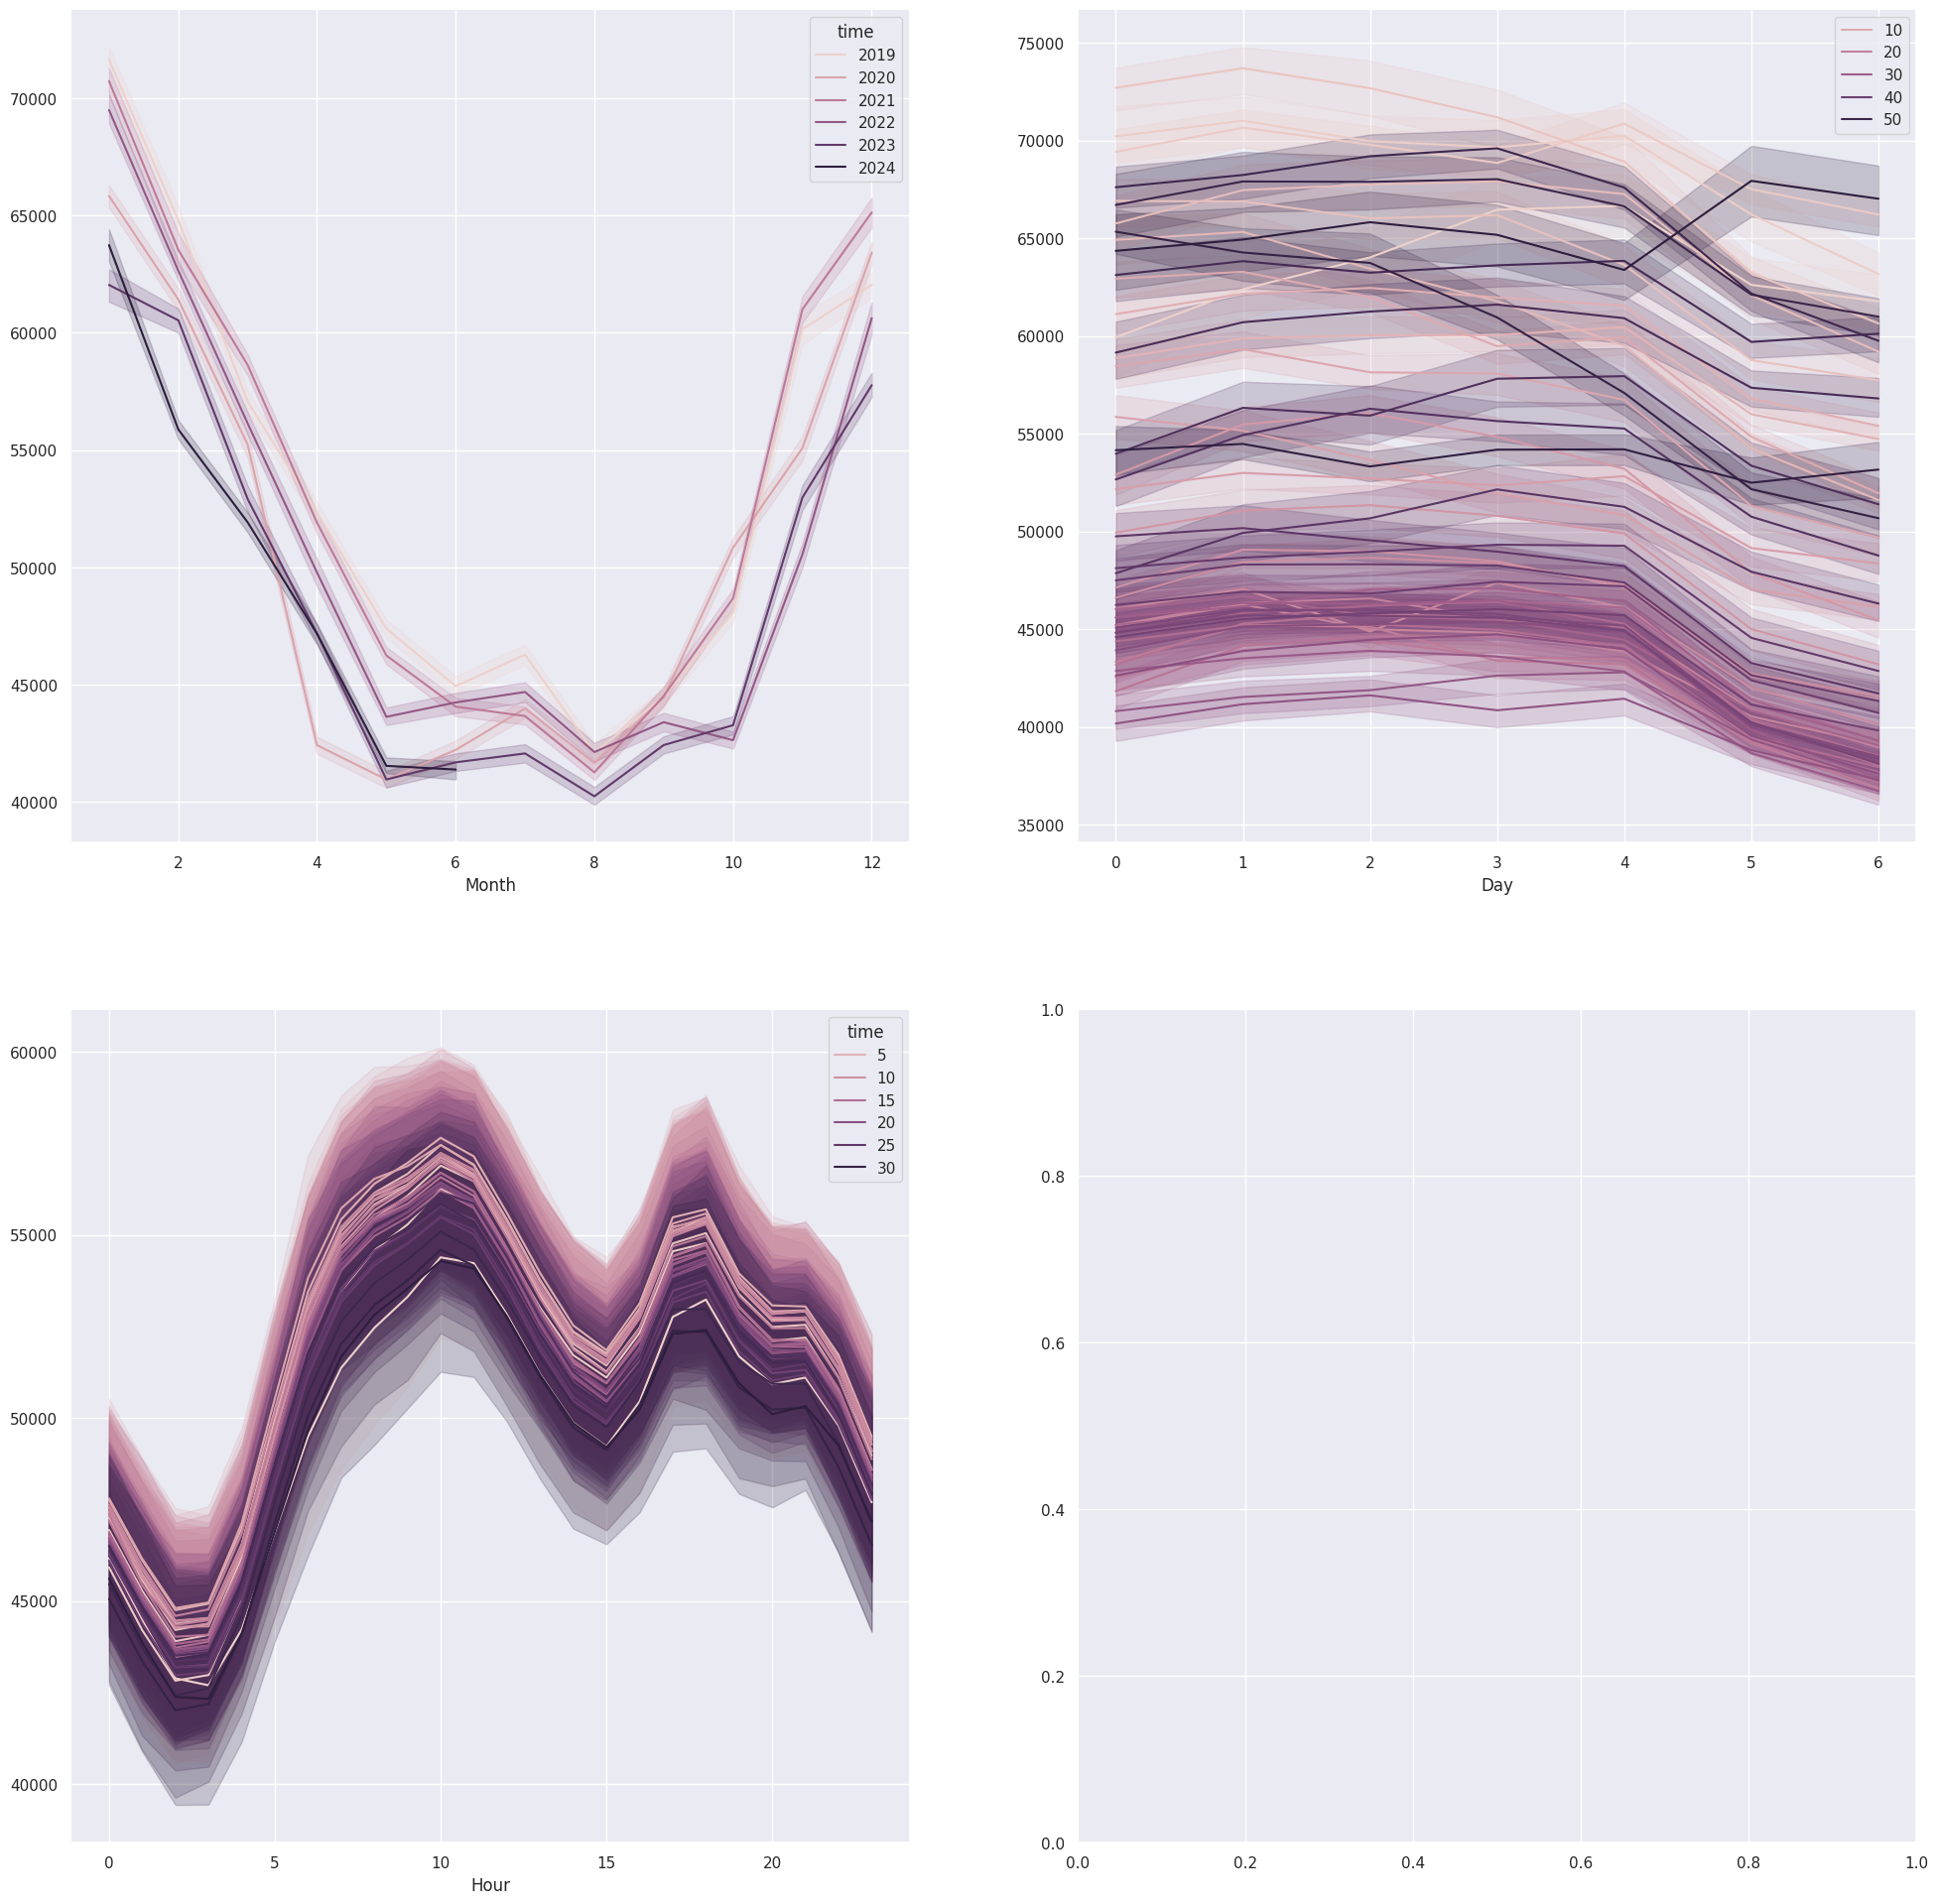

In [15]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(24, 24))
axs = axs.ravel()
sns.lineplot(x=y.index.month, y=y.values, hue=y.index.year, ax=axs[0])
sns.lineplot(x=y.index.dayofweek, y=y.values, hue=y.index.isocalendar().week.values.astype("int"), ax=axs[1])
sns.lineplot(x=y.index.hour, y=y.values, hue=y.index.day, ax=axs[2])

axs[0].set_xlabel("Month")
axs[1].set_xlabel("Day")
axs[2].set_xlabel("Hour")

axs = axs.reshape((2, 2))

From the partial correlation plot, we see the first three lags are correlated with the output so we will include them as features.

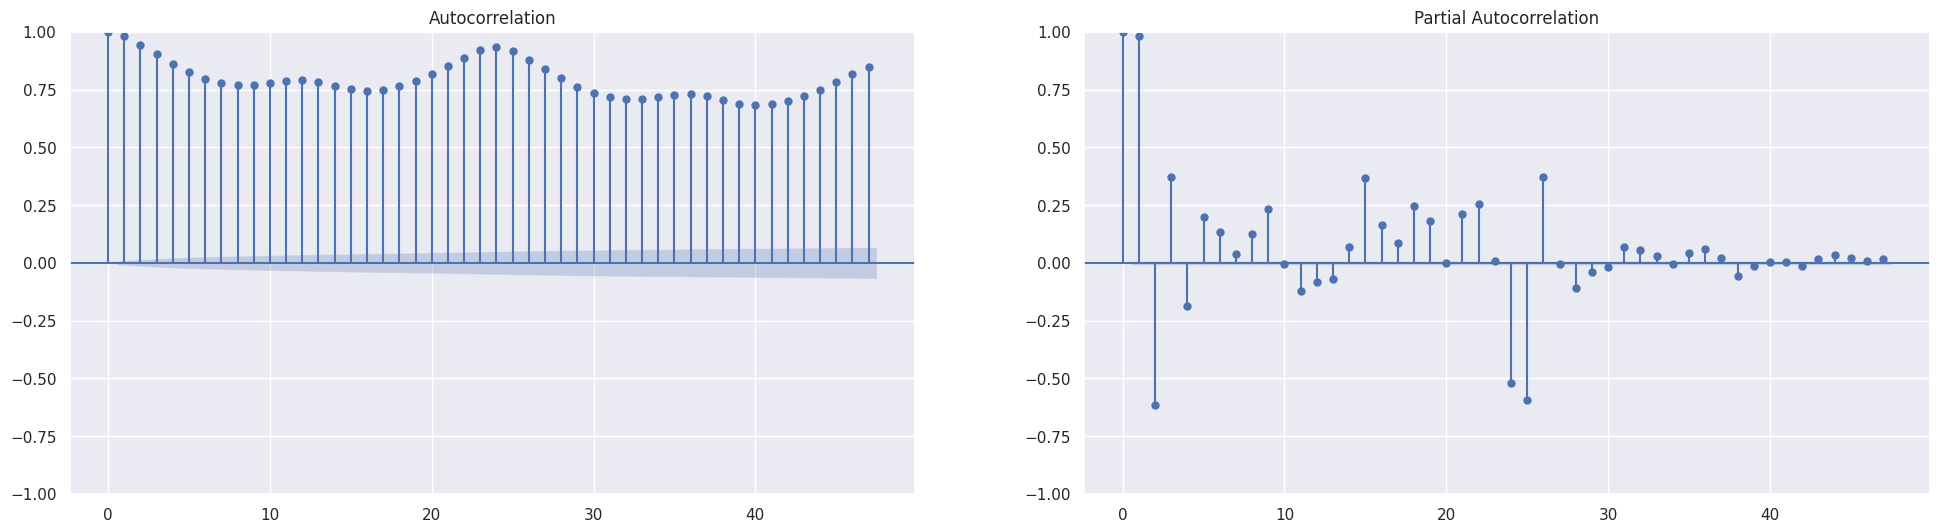

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(ncols=2, figsize=(24, 6))

_ = plot_acf(y, ax=axs[0])
_ = plot_pacf(y, ax=axs[1])

## Model building

In the previous section, we analyzed the seasonality of the series and found the periodicities of importance. We can now use these periodicities to build a model. The features we use for the forecasting model are
- The various periodic dummy columns
- A holiday column
- A lag version of the series
- A quadratic trend with intercept

We will then compare a Random Forest and LGBM algorithms to fit the data in-sample using a walk-forward cross-validation.

To reduce the load on this step, we will use as training sample all the data from "2019-01-01" except the last day (we will use as testing data), predict samples of 24h and backtest over the last two weeks of training. This will mean 14 retraining per iterations.

In [17]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster, backtesting_forecaster

In [20]:
max_periods_manual = [12, 24, 24 * 3, 24 * 7, 24 * 30 * 6, 24 * 365]
# Build useful features to model the trend and seasonality
X = features.BuildExogeneousFeatures(
    index=y.index,
    periods=max_periods_manual,
    max_fourier_order=3,
    country_holidays="FRA",
    order_trend=2,
)

## Simple training

We start by simply comparing the two algorithms using the simple train/val split and compare on the test value.

In [21]:
forecaster_rf = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=config.random_state, n_jobs=-1), lags=3)

forecaster_rf.fit(y.loc[idx_train], exog=X.loc[idx_train])

forecaster_lgbm = ForecasterAutoreg(
    regressor=LGBMRegressor(random_state=config.random_state, n_jobs=-1, verbose=-1), lags=3
)
forecaster_lgbm.fit(y.loc[idx_train], exog=X.loc[idx_train])

In [22]:
y_forecast_rf = forecaster_rf.predict(steps=predict_size, exog=X.loc[idx_forecast])
y_forecast_lgbm = forecaster_lgbm.predict(steps=predict_size, exog=X.loc[idx_forecast])

In [23]:
print(f"The MAPE for the Random Forest model is {mean_absolute_percentage_error(y.loc[idx_forecast], y_forecast_rf)}")
print(f"The MAPE for the LGBM model is {mean_absolute_percentage_error(y.loc[idx_forecast], y_forecast_lgbm)}")

The MAPE for the Random Forest model is 0.010892085939828147
The MAPE for the LGBM model is 0.02894443005112521


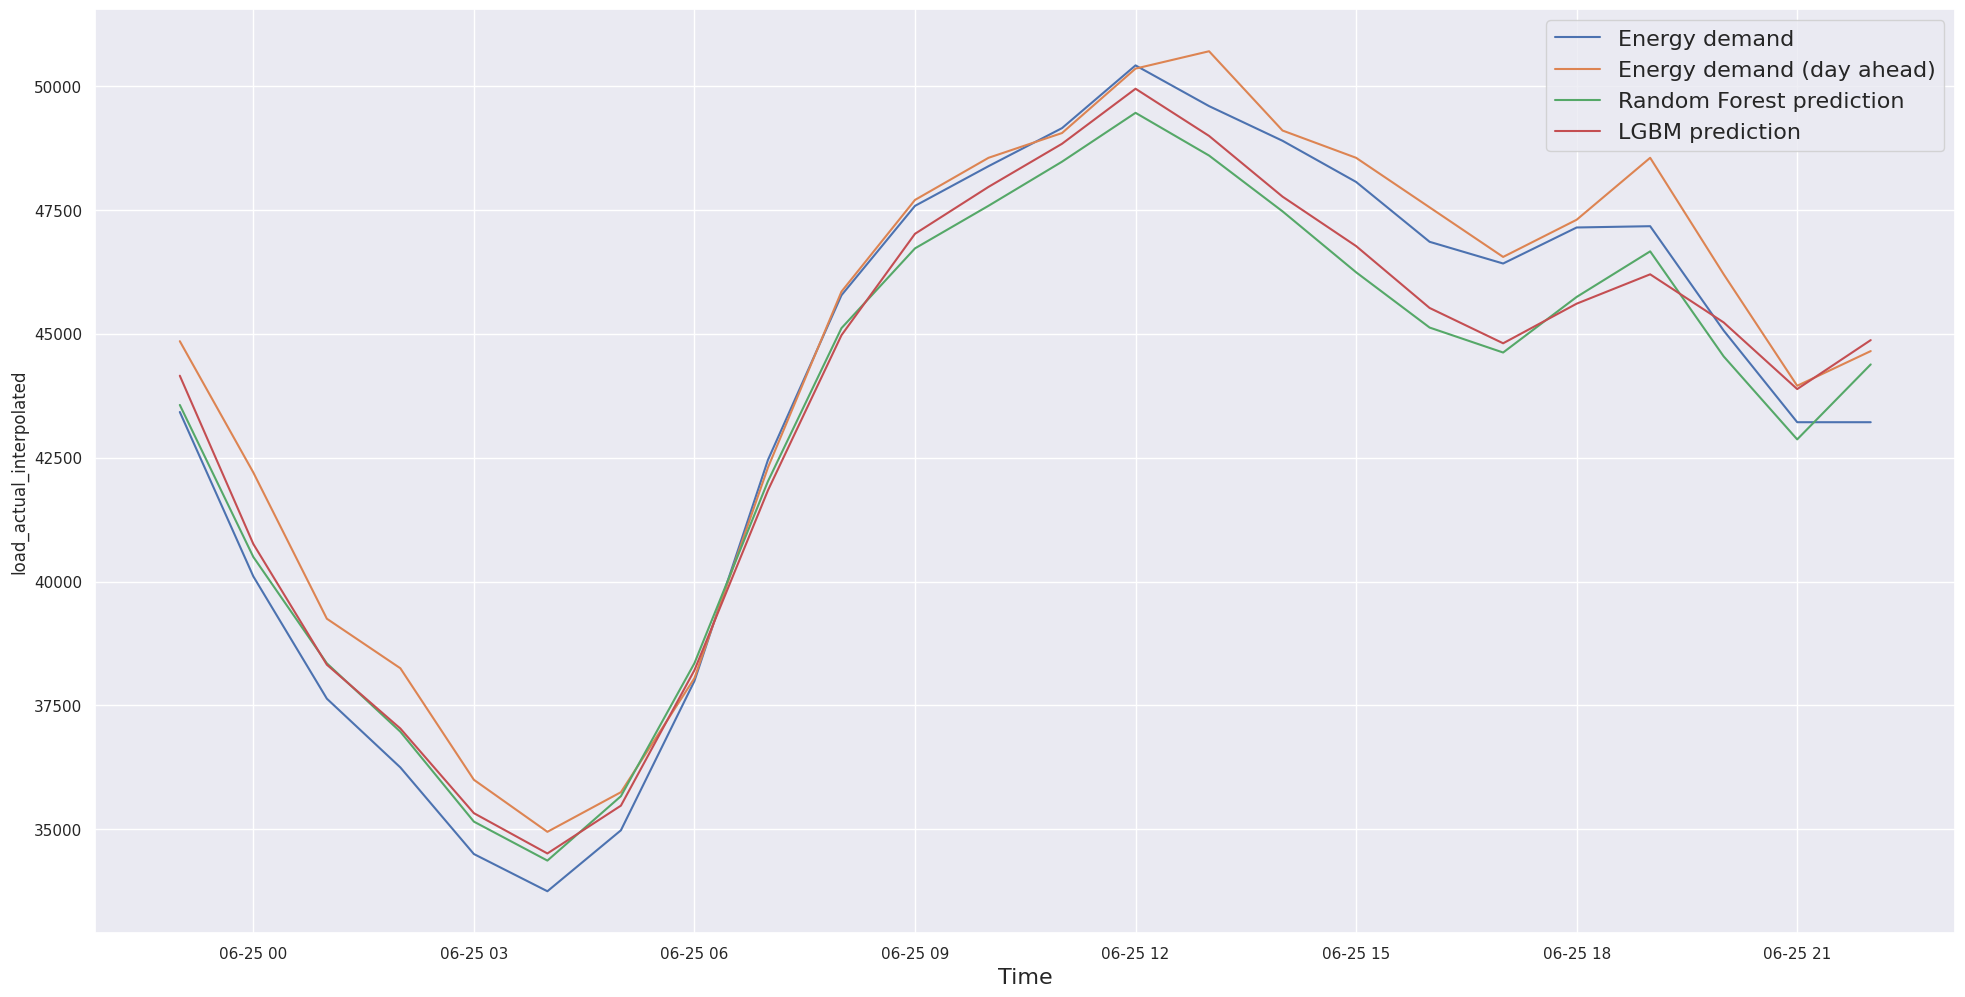

In [ ]:
fig, ax = plt.subplots(figsize=(24, 12))
ax = visualization.plot_series(y.loc[idx_forecast], ax=ax, label="Energy demand")
ax = visualization.plot_series(y_day_ahead.loc[idx_forecast], ax=ax, label="Energy demand (day ahead)")
ax = visualization.plot_series(y_forecast_rf, ax=ax, label="Random Forest prediction")
ax = visualization.plot_series(y_forecast_lgbm, ax=ax, label="LGBM prediction")

We can use backtesting to get a better sense of the accuracy of each model. We will refitting every week and predict one day at a time.

In [ ]:
results_rf = backtesting_forecaster(
    forecaster_rf,
    y.loc[idx_train],
    metric="mean_absolute_percentage_error",
    refit=refit_size,
    initial_train_size=idx_train_noval.sum(),
    steps=predict_size,
    exog=X[idx_train],
    show_progress=True,
    random_state=config.random_state,
)

100%|██████████| 14/14 [00:37<00:00,  2.67s/it]


In [ ]:
results_lgbm = backtesting_forecaster(
    forecaster_lgbm,
    y.loc[idx_train],
    metric="mean_absolute_percentage_error",
    refit=refit_size,
    initial_train_size=idx_train_noval.sum(),
    steps=predict_size,
    exog=X[idx_train],
    show_progress=True,
    random_state=config.random_state,
)

100%|██████████| 14/14 [00:00<00:00, 15.08it/s]


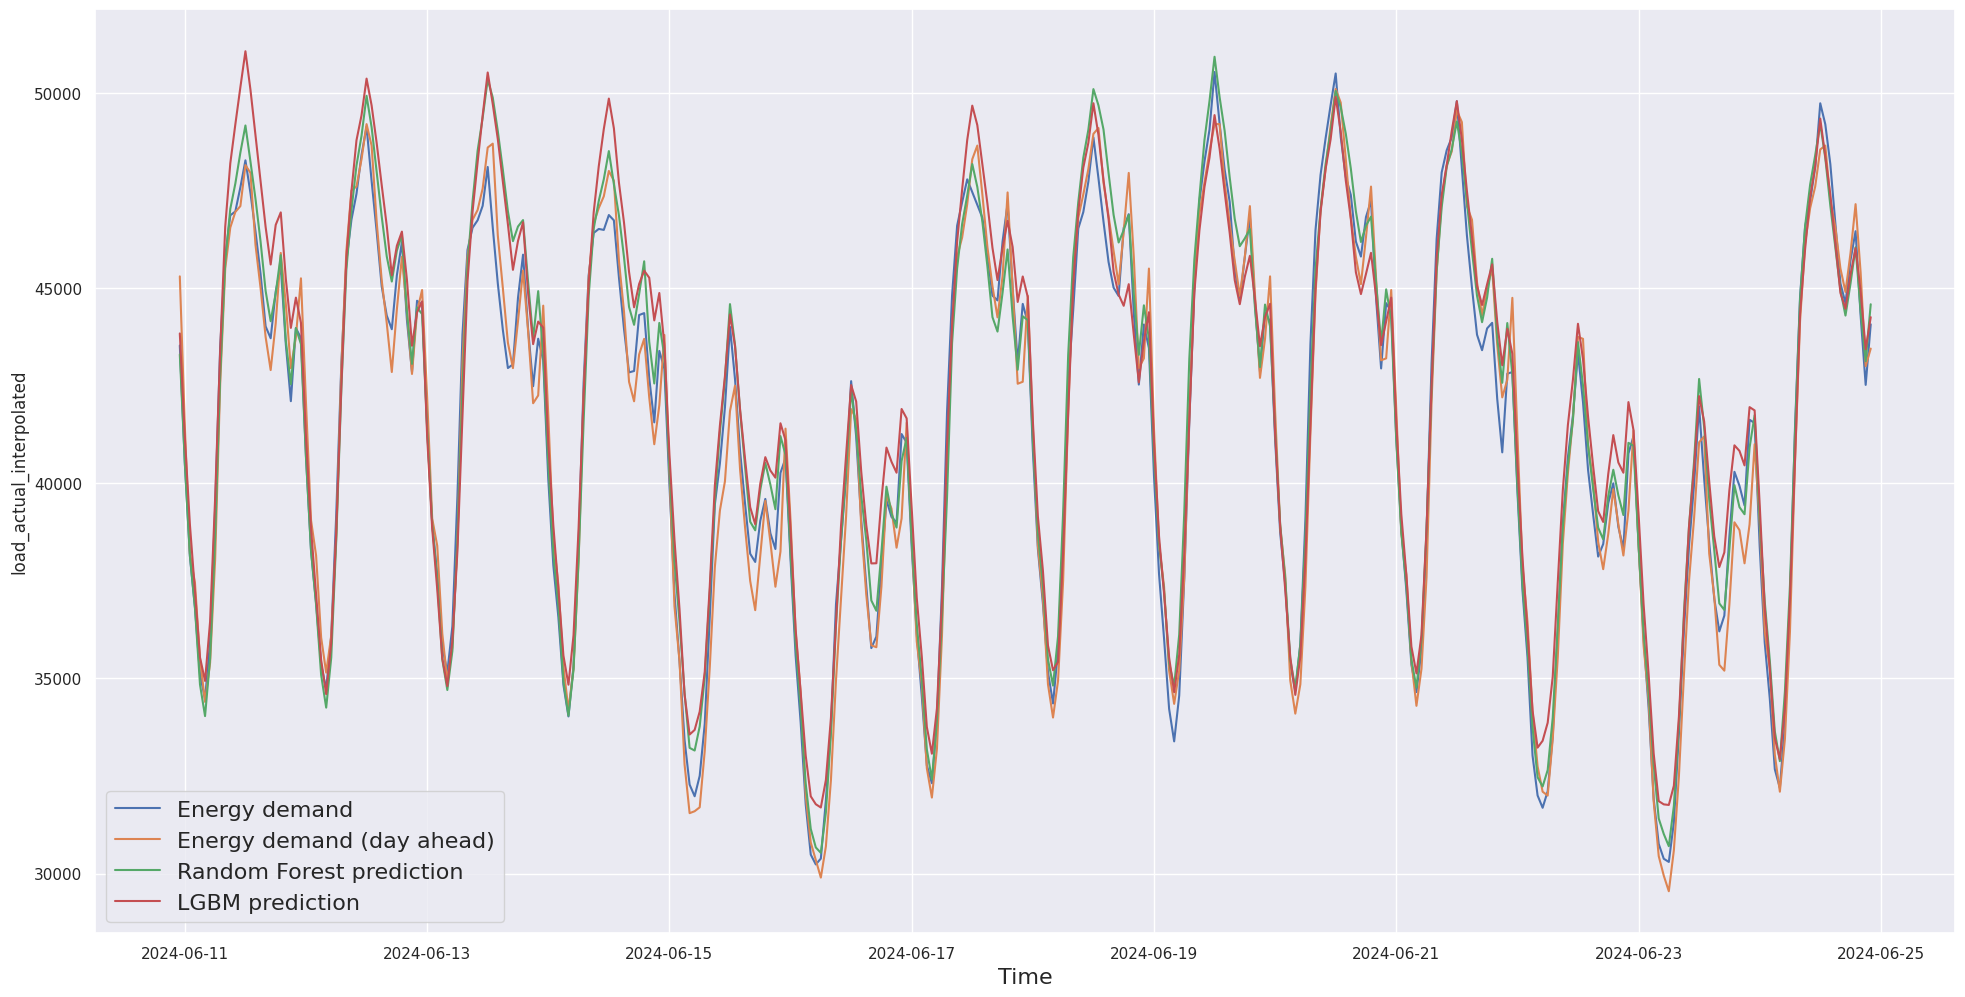

In [ ]:
fig, axs = plt.subplots(figsize=(24, 12), nrows=1)

_ = visualization.plot_series(y.loc[idx_val], ax=axs, label="Energy demand")
_ = visualization.plot_series(y_day_ahead.loc[idx_val], ax=axs, label="Energy demand (day ahead)")
_ = visualization.plot_series(results_rf[1]["pred"], ax=axs, label="Random Forest prediction")
_ = visualization.plot_series(results_lgbm[1]["pred"], ax=axs, label="LGBM prediction")

## Hyperparameter tuning

Now we can tune both models and see which one performs best!

In [ ]:
# Parameter grid for hypertuning
def search_space_rf(trial):
    search_space = {
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=25),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 10, 200, step=10),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", 1.0]),
        "lags": trial.suggest_categorical("lags", [3]),
    }
    return search_space


results_hs_rf, frozen_trial_hs_rf = bayesian_search_forecaster(
    forecaster=forecaster_rf,
    y=y[idx_train],
    search_space=search_space_rf,
    steps=predict_size,
    refit=refit_size,
    initial_train_size=idx_train_noval.sum(),
    metric="mean_absolute_percentage_error",
    exog=X[idx_train],
    # n_jobs=-1,
    show_progress=True,
    return_best=True,
    engine="optuna",
    random_state=config.random_state,
    verbose=False,
    n_trials=5,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Best trial: 2. Best value: 0.0598539: 100%|██████████| 5/5 [02:59<00:00, 35.99s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'bootstrap': True, 'n_estimators': 450, 'max_depth': 7, 'min_samples_split': 180, 'max_features': 'sqrt'}
  Backtesting metric: 0.059853880696645004



In [ ]:
print("The results from the hyperparameter tuning of the Random Forest model are")
display(results_hs_rf.iloc[0])

The results from the hyperparameter tuning of the Random Forest model are


lags                                                                      [1, 2, 3]
params                            {'bootstrap': True, 'n_estimators': 450, 'max_...
mean_absolute_percentage_error                                             0.059854
bootstrap                                                                      True
n_estimators                                                                    450
max_depth                                                                         7
min_samples_split                                                               180
max_features                                                                   sqrt
Name: 2, dtype: object

In [ ]:
print("The most important features are")
display(forecaster_rf.get_feature_importances())

The most important features are


feature  importance
0           lag_1    0.297642
1           lag_2    0.265213
2           lag_3    0.174908
35      cos_18760    0.109601
34      sin_18760    0.021591
6           trend    0.013429
7   trend_squared    0.012624
14        sin_224    0.012522
13        cos_124    0.012227
22       sin_1168    0.011639
21        sin_372    0.008224
37      cos_28760    0.007493
4         weekend    0.006775
39      cos_38760    0.006617
28      sin_14320    0.006298
36      sin_28760    0.005931
38      sin_38760    0.005642
29      cos_14320    0.003346
8         cos_112    0.002521
16        cos_324    0.001512
23       cos_1168    0.001412
30      sin_24320    0.001279
25       cos_2168    0.001278
19        sin_272    0.001151
31      cos_24320    0.001045
26       sin_3168    0.001011
15        sin_324    0.000917
18        cos_172    0.000896
9         sin_212    0.000878
24       sin_2168    0.000762
3        holidays    0.000682
10        cos_212    0.000634
17        sin_172    0.000570
27       cos_3168    0.000528
33      cos_34320    0.000324
32      sin_34320    0.000298
11        sin_312    0.000296
20        cos_272    0.000179
12        cos_312    0.000105
5           const    0.000000

In [ ]:
# Parameter grid for hypertuning
def search_space_lgbm(trial):
    search_space = {
        "num_leaves": trial.suggest_int("num_leaves", 10, 60),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.5),
        "lags": trial.suggest_categorical("lags", [3]),
    }
    return search_space


results_hs_lgbm, frozen_trial_hs_lgbm = bayesian_search_forecaster(
    forecaster=forecaster_lgbm,
    y=y[idx_train],
    search_space=search_space_lgbm,
    steps=predict_size,
    refit=refit_size,
    initial_train_size=idx_train_noval.sum(),
    metric="mean_absolute_percentage_error",
    exog=X[idx_train],
    # n_jobs=-1,
    show_progress=True,
    return_best=True,
    engine="optuna",
    random_state=config.random_state,
    verbose=False,
    n_trials=10,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Best trial: 4. Best value: 0.022959: 100%|██████████| 10/10 [00:41<00:00,  4.20s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'num_leaves': 53, 'max_depth': 10, 'learning_rate': 0.05738575653935178, 'n_estimators': 120, 'reg_alpha': 0.21391784707404854}
  Backtesting metric: 0.02295904389661838



In [ ]:
print("The results from the hyperparameter tuning of the LGBM model are")
display(results_hs_lgbm.iloc[0])

The results from the hyperparameter tuning of the LGBM model are


lags                                                                      [1, 2, 3]
params                            {'num_leaves': 53, 'max_depth': 10, 'learning_...
mean_absolute_percentage_error                                             0.022959
num_leaves                                                                     53.0
max_depth                                                                      10.0
learning_rate                                                              0.057386
n_estimators                                                                  120.0
reg_alpha                                                                  0.213918
Name: 4, dtype: object

In [ ]:
print("The most important features are")
display(forecaster_lgbm.get_feature_importances())

The most important features are


feature  importance
0           lag_1         976
6           trend         604
13        cos_124         594
21        sin_372         556
14        sin_224         470
8         cos_112         423
9         sin_212         304
35      cos_18760         216
22       sin_1168         214
34      sin_18760         206
15        sin_324         166
16        cos_324         162
1           lag_2         154
2           lag_3         119
4         weekend         116
24       sin_2168         107
11        sin_312          93
10        cos_212          80
23       cos_1168          80
36      sin_28760          76
12        cos_312          68
37      cos_28760          67
26       sin_3168          65
3        holidays          54
28      sin_14320          45
29      cos_14320          44
38      sin_38760          40
27       cos_3168          40
39      cos_38760          36
30      sin_24320          30
25       cos_2168          22
33      cos_34320           5
32      sin_34320           4
17        sin_172           2
31      cos_24320           1
20        cos_272           1
19        sin_272           0
18        cos_172           0
7   trend_squared           0
5           const           0

We used walk-forward validation to tune the hyperparameters of the model. Now we compare the testing data.

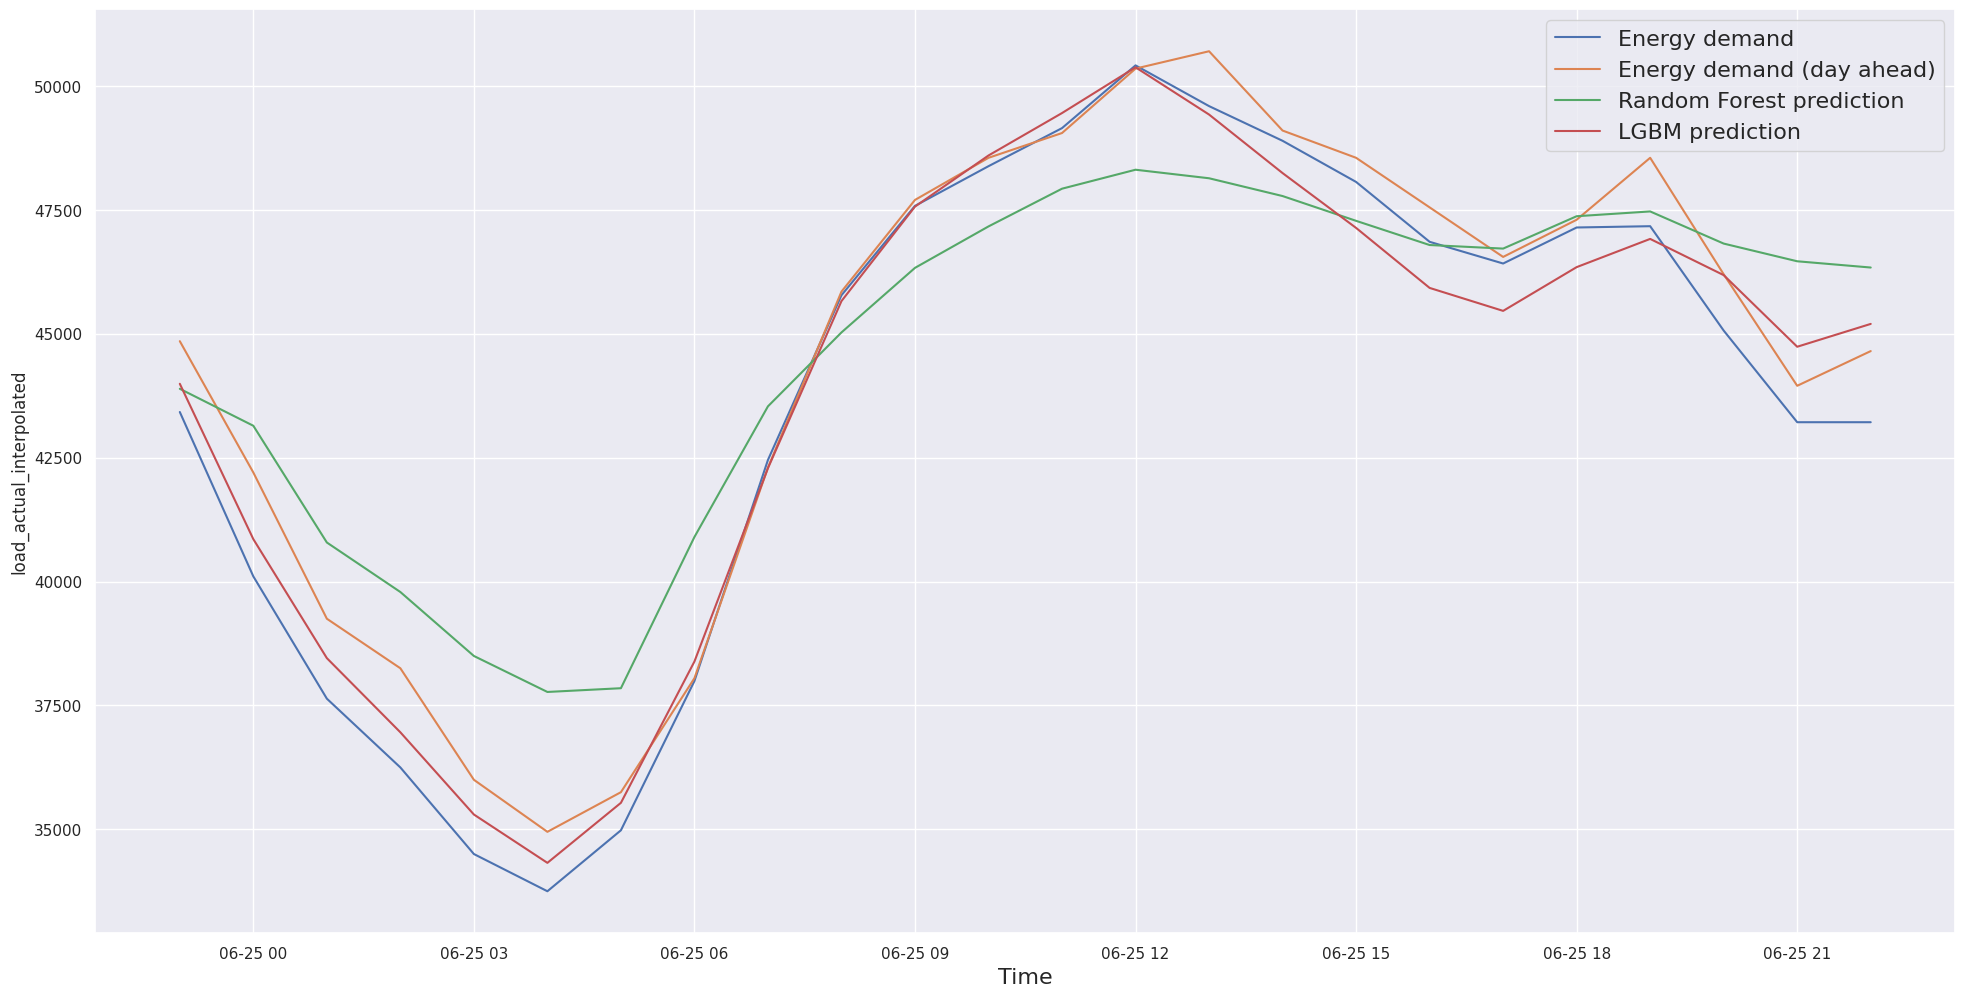

In [ ]:
fig, ax = plt.subplots(figsize=(24, 12))
ax = visualization.plot_series(y.loc[idx_forecast], ax=ax, label="Energy demand")
ax = visualization.plot_series(y_day_ahead.loc[idx_forecast], ax=ax, label="Energy demand (day ahead)")
ax = visualization.plot_series(
    forecaster_rf.predict(predict_size, exog=X.loc[idx_forecast]), ax=ax, label="Random Forest prediction"
)
ax = visualization.plot_series(
    forecaster_lgbm.predict(predict_size, exog=X.loc[idx_forecast]), ax=ax, label="LGBM prediction"
)

In [ ]:
metric_rf, pred_rf = backtesting_forecaster(
    forecaster_rf,
    y.loc[idx_train],
    metric="mean_absolute_percentage_error",
    refit=False,
    initial_train_size=idx_train_noval.sum(),
    steps=predict_size,
    exog=X[idx_train],
    show_progress=True,
    random_state=config.random_state,
)

metric_lgbm, pred_lgbm = backtesting_forecaster(
    forecaster_lgbm,
    y.loc[idx_train],
    metric="mean_absolute_percentage_error",
    refit=False,
    initial_train_size=idx_train_noval.sum(),
    steps=predict_size,
    exog=X[idx_train],
    show_progress=True,
    random_state=config.random_state,
)

100%|██████████| 14/14 [00:00<00:00, 33.47it/s]


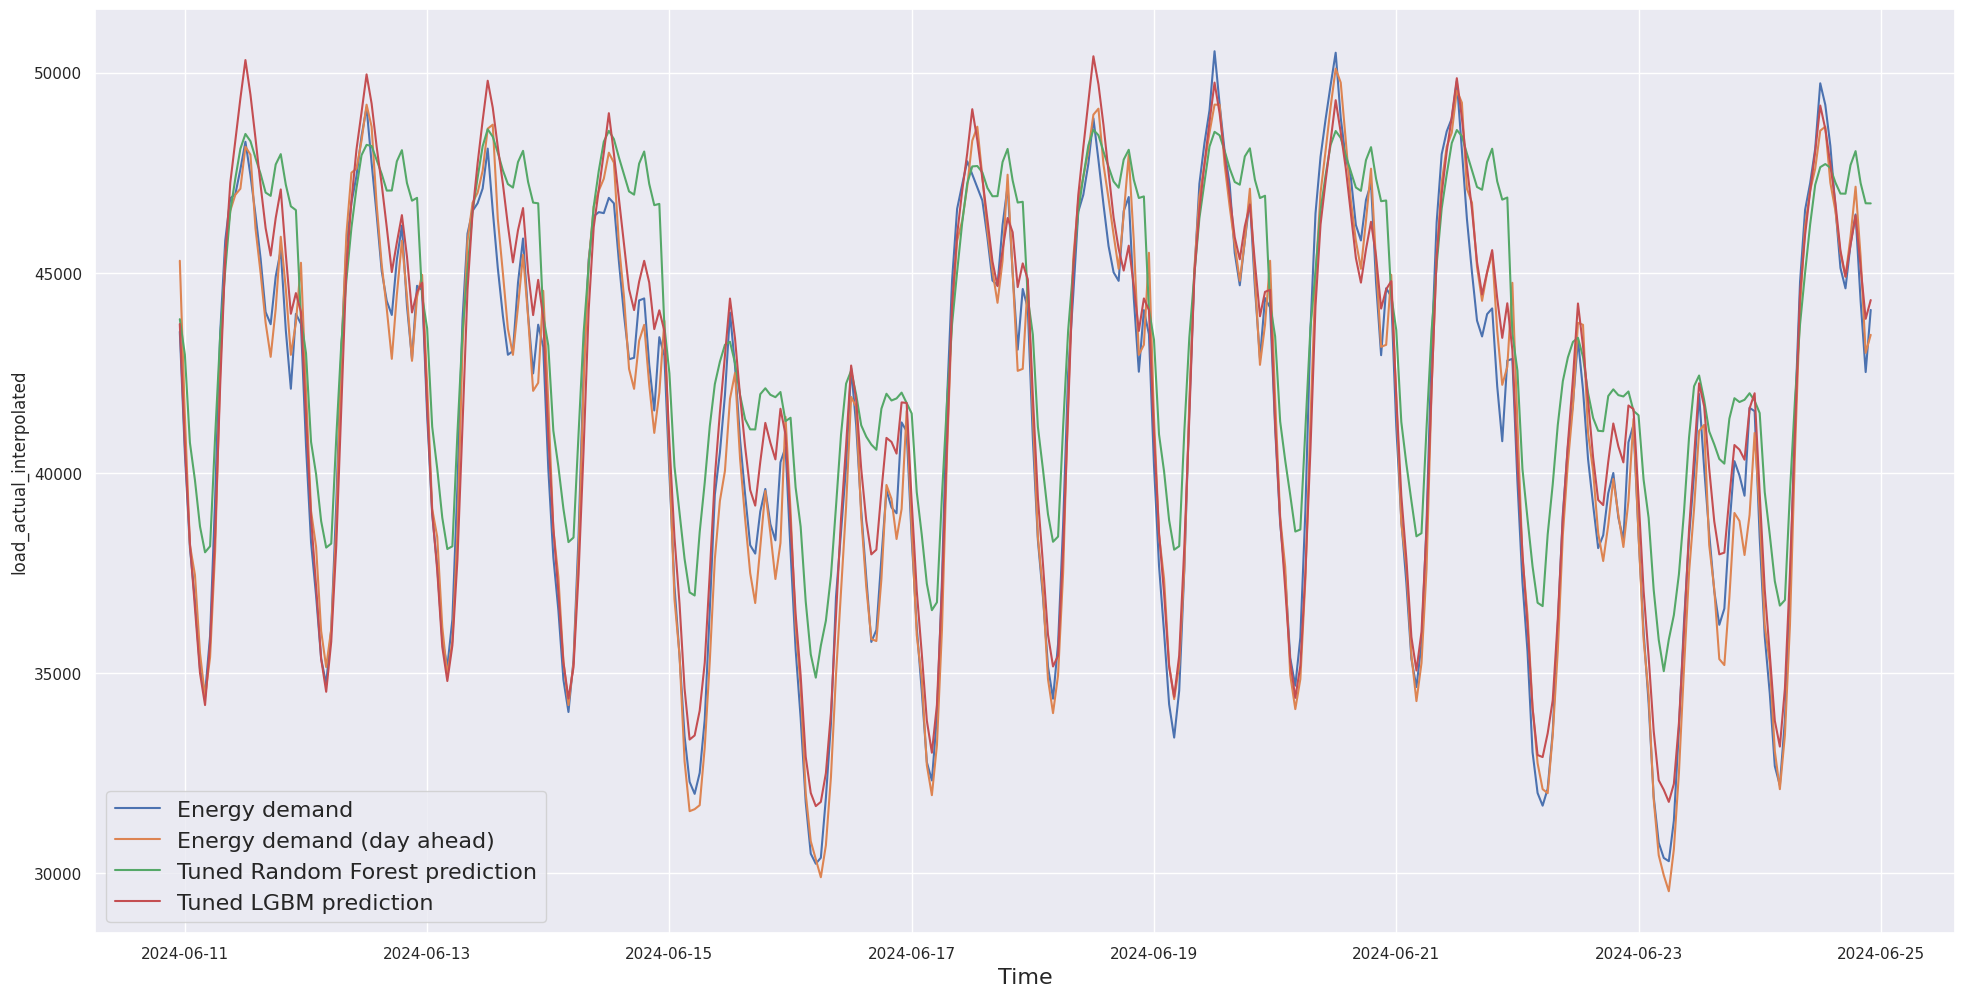

In [ ]:
fig, axs = plt.subplots(figsize=(24, 12), nrows=1)

_ = visualization.plot_series(y.loc[idx_val], ax=axs, label="Energy demand")
_ = visualization.plot_series(y_day_ahead.loc[idx_val], ax=axs, label="Energy demand (day ahead)")
_ = visualization.plot_series(pred_rf["pred"], ax=axs, label="Tuned Random Forest prediction")
_ = visualization.plot_series(pred_lgbm["pred"], ax=axs, label="Tuned LGBM prediction")

Finally we have a tuned LGBM model which is very performant and quite close to the performance of the provided forecast! We will use this strategy and make a demo out of it.